In [176]:
import scipy.io as sci
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pylab
import statsmodels.api as sm

### Separate based on response (flash first or beep first)

In [3]:
resppath = 'StabilityofPCommonData/NumerosityTaskUnformatted/*.mat'
respfiles = np.array(glob.glob(resppath))
datapath = 'StabilityofPCommonData/NumerosityTaskData/*.mat'
datafiles = np.array(glob.glob(datapath))

In [4]:
# filenames for f or b responses
respf = np.empty((1, 1))
respb = np.empty((1, 1))
for names in respfiles:
    mat = sci.loadmat(names)
    resp = mat['respCode']
    if(resp == "f"):
        respf = np.append(respf, names)
    else:
        respb = np.append(respb, names)
respf = respf[1:]
respb = respb[1:]

In [5]:
# index for flash first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexf = list()
c = 0
for x in respfiles:
    if x in respf:
        indexf.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
dataf = datafiles[indexf]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexf = np.delete(indexf, missing)

### Extract trial data and response times for flash trials

In [6]:
# further subset into flash reported and insert indices for subject id  
dataf = datafiles[indexf]

subjidf = np.array([2,5,7,7,11,11,12,12,15,15,19,20,20,23,28,31,32,32,35,36,37,37,40,
                   40,41,41,42,50,50,53,53,54,54,57,57,60,60,61,61,64])
trialsf = np.empty((1,5))
for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidf[i]), axis=1)
    trialsf = np.vstack((trialsf, arr))
trialsf = trialsf[1:]
print(len(trialsf))

# add a response column to second column, 1 if correct 0 if wrong
respcolf = np.empty((1,1))
respcolb = np.empty((1,1))

for rows in trialsf:
    if rows[1] == rows[3]:
        respcolf = np.append(respcolf, 1)
    else:
        respcolf = np.append(respcolf, 0)
respcolf = respcolf[1:]

for rows in trialsf:
    if rows[2] == rows[4]:
        respcolb = np.append(respcolb, 1)
    else:
        respcolb = np.append(respcolb, 0)
respcolb = respcolb[1:]

trialsf = np.insert(trialsf, 1, respcolf, axis=1)
trialsf = np.insert(trialsf, 2, respcolb, axis=1)

14400


In [7]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respf = respfiles[indexf]

for i in np.arange(0, len(respf)):
    mat = sci.loadmat(respf[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]
#print(len(resptimes))

trialsf = pd.DataFrame(np.insert(trialsf, 1, resptimes, axis = 1), 
                        columns=['Subj_id', 'rt', 'responsef', 'responseb', 'flashpres', 'beeppres', 'flashresp', 'beepresp'])
#trialsf = np.insert(trialsf, 1, resptimes, axis = 1)

### Remove outliers for comparing

In [8]:
trialsfsd = trialsf['rt'].std()
trialsf = trialsf.loc[(trialsf['rt'] <= trialsfsd*3) & (trialsf['rt'] > 0)]

### Further subset into congruent, incongruent, and unimodal rows

In [9]:
congf = trialsf.loc[trialsf['flashpres'] == trialsf['beeppres']]

incongf = trialsf.loc[(trialsf['flashpres'] != trialsf['beeppres']) & (trialsf['flashpres'] != 0) & (trialsf['beeppres'] != 0)]

unif = trialsf.loc[(trialsf['flashpres'] != 0) & (trialsf['beeppres'] == 0)]

##### The formatting for the data to be inputed is as follows:
Column 1: Subject ID <br>
Column 2: Response Time <br>
Column 3: Response for flashes  <br>
Column 4: Response for beeps <br>
Column 5: Flashes presented <br>
Column 6: Beeps presented <br>
Column 7: Flashes reported <br>
Column 8: Beeps reported <br>

### Repeat for beep trials

In [10]:
# index for beep first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexb = list()
c = 0
for x in respfiles:
    if x in respb:
        indexb.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
datab = datafiles[indexb]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexb = np.delete(indexb, missing)

In [11]:
datab = datafiles[indexb]
subjidb = np.array([6,6,9,10,10,13,14,14,16,16,21,21,22,25,25,26,26,
                    29,30,30,34,36,39,39,42,44,44,47,47,48,48,51,51,59,59,62,62,63,63,64])
trialsb = np.empty((1,5))
for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidb[i]), axis=1)
    trialsb = np.vstack((trialsb, arr))
trialsb = trialsb[1:]
#print((trialsb))

count = 0
accvec = np.empty((1,1))
for rows in trialsb:
    if (rows[1] == 3) & (rows[2] == 3):
        accvec = np.append(accvec, rows[2] - rows[4])
accvec = accvec[1:]
unique, counts = np.unique(accvec, return_counts=True)
print(dict(zip(unique, counts)))
print(len(accvec))
print(counts[1])
print(float(counts[1]) / float(len(accvec)))
        
# add a response column to second column, 1 if correct 0 if wrong
respcolf = np.empty((1,1))
respcolb = np.empty((1,1))

for rows in trialsb:
    if rows[1] == rows[3]:
        respcolf = np.append(respcolf, 1)
    else:
        respcolf = np.append(respcolf, 0)
respcolf = respcolf[1:]

for rows in trialsb:
    if rows[2] == rows[4]:
        respcolb = np.append(respcolb, 1)
    else:
        respcolb = np.append(respcolb, 0)
respcolb = respcolb[1:]

trialsb = np.insert(trialsb, 1, respcolf, axis=1)
trialsb = np.insert(trialsb, 2, respcolb, axis=1)

{0.0: 470, 1.0: 100, -1.0: 30}
600
470
0.783333333333


In [12]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respb = respfiles[indexb]

for i in np.arange(0, len(respb)):
    mat = sci.loadmat(respb[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]

#trialsb = np.insert(trialsb, 1, resptimes, axis = 1)
trialsb = pd.DataFrame(np.insert(trialsb, 1, resptimes, axis = 1), 
                        columns=['Subj_id', 'rt', 'responsef', 'responseb', 'flashpres', 'beeppres', 'flashresp', 'beepresp'])

In [13]:
trialsbsd = trialsb['rt'].std()
trialsb = trialsb.loc[(trialsb['rt'] <= trialsbsd*3) & (trialsb['rt'] > 0)]

In [14]:
congb = trialsb.loc[trialsb['flashpres'] == trialsb['beeppres']]

incongb = trialsb.loc[(trialsb['flashpres'] != trialsb['beeppres']) & (trialsb['flashpres'] != 0) & (trialsb['beeppres'] != 0)]

unib = trialsb.loc[(trialsb['flashpres'] == 0) & (trialsb['beeppres'] != 0)]

In [15]:
cong1f = congf.loc[congf['flashpres'] == 1]
cong2f = congf.loc[congf['flashpres'] == 2]
cong3f = congf.loc[congf['flashpres'] == 3]
cong4f = congf.loc[congf['flashpres'] == 4]

cong1b = congb.loc[congb['flashpres'] == 1]
cong2b = congb.loc[congb['flashpres'] == 2]
cong3b = congb.loc[congb['flashpres'] == 3]
cong4b = congb.loc[congb['flashpres'] == 4]

incong1b = incongb.loc[incongb['flashpres'] == 1]
incong2b = incongb.loc[incongb['flashpres'] == 2]
incong3b = incongb.loc[incongb['flashpres'] == 3]
incong4b = incongb.loc[incongb['flashpres'] == 4]

uni1f = unif.loc[unif['flashpres'] == 1]
uni2f = unif.loc[unif['flashpres'] == 2]
uni3f = unif.loc[unif['flashpres'] == 3]
uni4f = unif.loc[unif['flashpres'] == 4]

uni1b = unib.loc[unib['beeppres'] == 1]
uni2b = unib.loc[unib['beeppres'] == 2]
uni3b = unib.loc[unib['beeppres'] == 3]
uni4b = unib.loc[unib['beeppres'] == 4]

unifacc = float(len(unif.loc[unif['responsef'] == 1])) / float(len(unif))
unibacc = float(len(unib.loc[unib['responsef'] == 1])) / float(len(unib))

### Plot response times for both 

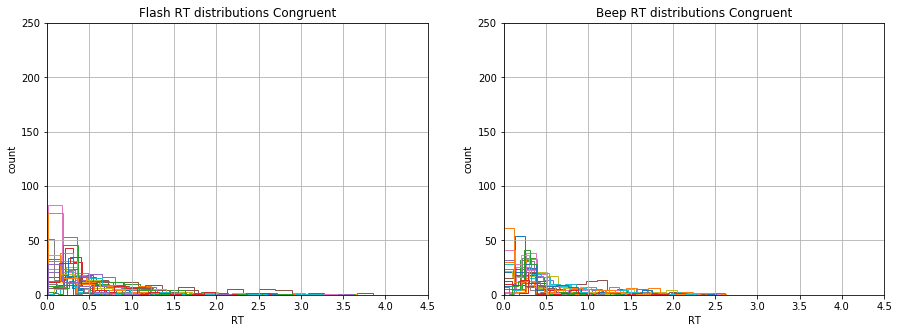

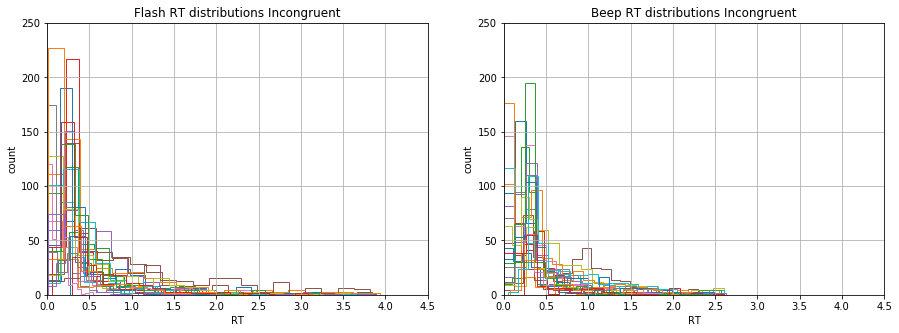

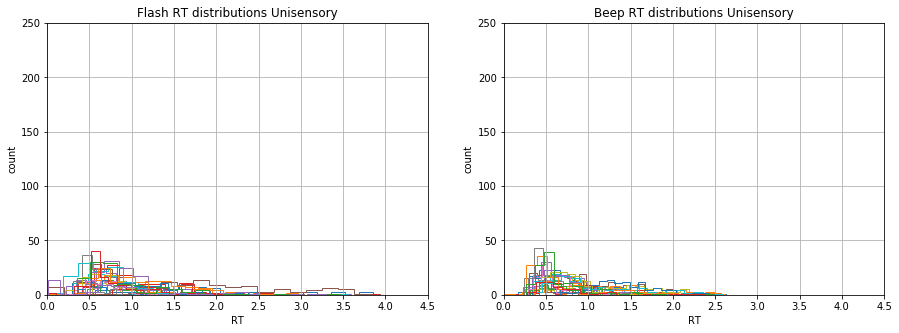

In [16]:
#test = hddm.utils.flip_errors(congfdata)

# compare congruent 
congfig = plt.figure(figsize=(15, 5))
ax = congfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Congruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in congf.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = congfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Congruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in congb.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# compare incongruent
incongfig = plt.figure(figsize=(15, 5))
ax = incongfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Incongruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in incongf.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = incongfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Incongruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in incongb.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# compare unisensory 
unifig = plt.figure(figsize=(15, 5))
ax = unifig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in unif.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = unifig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Unisensory')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in unib.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)


1.0    1355
0.0    1009
Name: responsef, dtype: int64


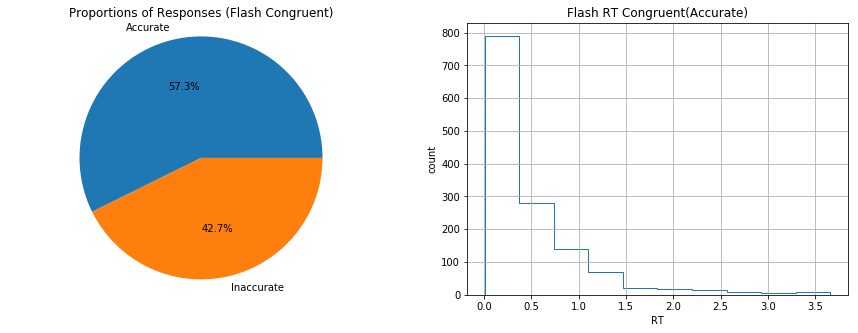

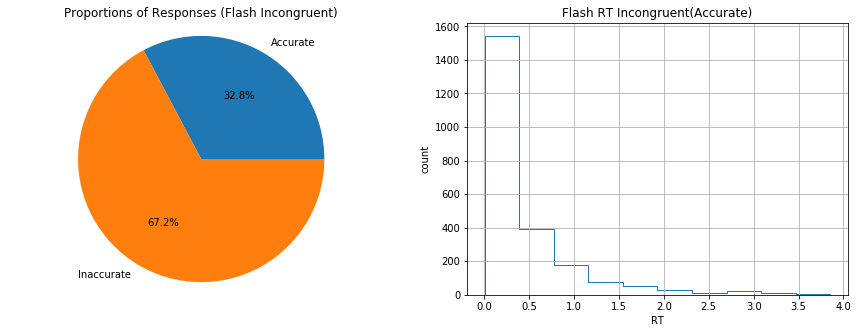

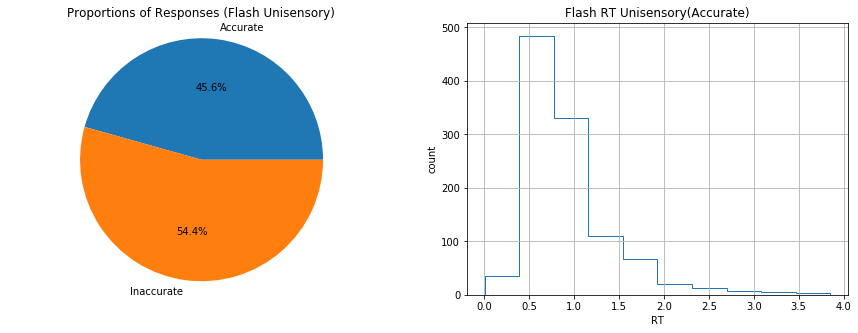

In [194]:
print(congf['responsef'].value_counts())
sizes = [congf['responsef'].value_counts()[1], congf['responsef'].value_counts()[0]]
labels = ['Accurate', 'Inaccurate']

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121, title='Proportions of Responses (Flash Congruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT Congruent(Accurate)')
#for i, subj_data in congf.groupby('response'):
#    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
congf.loc[congf['responsef'] == 1].rt.hist(histtype='step', ax = ax)

    
#print(incongfdata['response'].value_counts())
sizes = [incongf['responsef'].value_counts()[1], incongf['responsef'].value_counts()[0]]
labels = ['Accurate', 'Inaccurate']

fig2 = plt.figure(figsize=(15, 5))
ax = fig2.add_subplot(121, title='Proportions of Responses (Flash Incongruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig2.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT Incongruent(Accurate)')
#for i, subj_data in incongf.groupby('response'):
#    subj_data.rt.hist(bins=20, histtype='step', edgecolor="green", ax=ax)
incongf.loc[incongf['responsef'] == 1].rt.hist(histtype='step', ax = ax)    

    
#print(unifdata['response'].value_counts())
sizes = [unif['responsef'].value_counts()[1], unif['responsef'].value_counts()[0]]
labels = ['Accurate', 'Inaccurate']

fig3 = plt.figure(figsize=(15, 5))
ax = fig3.add_subplot(121, title='Proportions of Responses (Flash Unisensory)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig3.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT Unisensory(Accurate)')
#for i, subj_data in unif.groupby('response'):
#    subj_data.rt.hist(bins=20, histtype='step', edgecolor="green", ax=ax)
unif.loc[unif['responsef'] == 1].rt.hist(histtype='step', ax = ax)    

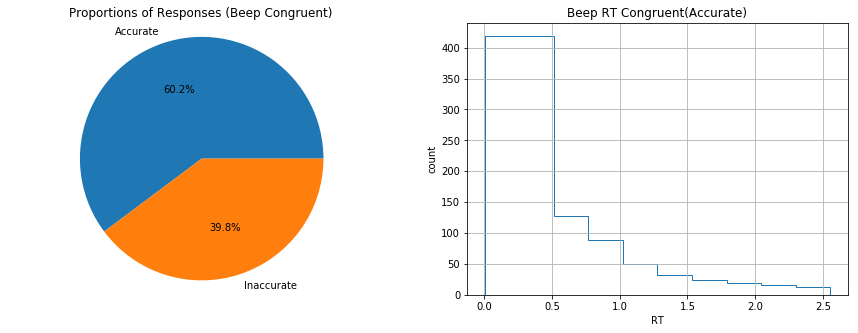

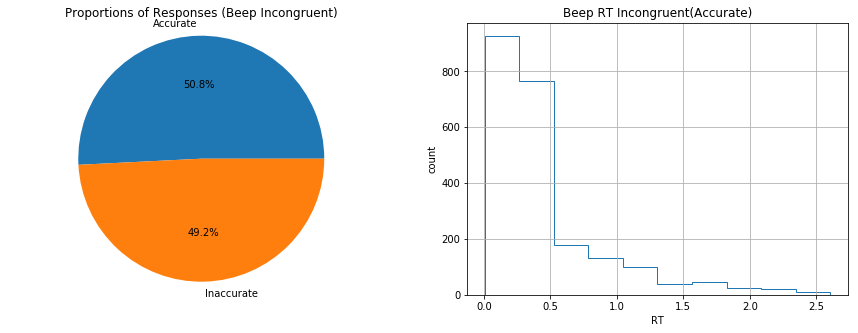

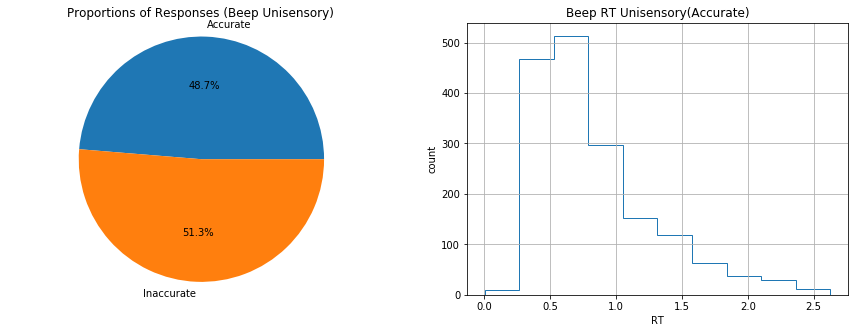

In [195]:
#### print(congb['responsef'].value_counts())
sizes = [congb['responseb'].value_counts()[1], congb['responsef'].value_counts()[0]]
labels = ['Accurate', 'Inaccurate']

fig5 = plt.figure(figsize=(15, 5))
ax = fig5.add_subplot(121, title='Proportions of Responses (Beep Congruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig5.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT Congruent(Accurate)')
#for i, subj_data in congb.groupby('response'):
#    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
congb.loc[congb['responsef'] == 1].rt.hist(histtype='step', ax = ax)    


#print(incongbdata['response'].value_counts())
sizes = [incongb['responseb'].value_counts()[1], incongb['responsef'].value_counts()[0]]
labels = ['Accurate', 'Inaccurate']

fig6 = plt.figure(figsize=(15, 5))
ax = fig6.add_subplot(121, title='Proportions of Responses (Beep Incongruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig6.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT Incongruent(Accurate)')
#for i, subj_data in incongb.groupby('response'):
#    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
incongb.loc[incongb['responsef'] == 1].rt.hist(histtype='step', ax = ax)    
    
    
#print(unibdata['response'].value_counts())
sizes = [uni1b['responseb'].value_counts()[1], unib['responseb'].value_counts()[0]]
labels = ['Accurate', 'Inaccurate']

fig7 = plt.figure(figsize=(15, 5))
ax = fig7.add_subplot(121, title='Proportions of Responses (Beep Unisensory)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig7.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT Unisensory(Accurate)')
#for i, subj_data in unib.groupby('response'):
#    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
unib.loc[unib['responseb'] == 1].rt.hist(histtype='step', ax = ax)    

### Compare large and small incongruencies

In [19]:
smallincf = trialsf.loc[((trialsf['flashpres'] == 1) & (trialsf['beeppres'] == 2))]
smallincf = smallincf.append(trialsf.loc[((trialsf['flashpres'] == 2) & (trialsf['beeppres'] == 1))])

largeincf = trialsf.loc[(trialsf['flashpres'] == 1) & (trialsf['beeppres'] == 4)]
largeincf = largeincf.append(trialsf.loc[((trialsf['flashpres'] == 4) & (trialsf['beeppres'] == 1))])

smallincb = trialsb.loc[(trialsb['flashpres'] == 1) & (trialsb['beeppres'] == 2)]
smallincb = smallincb.append(trialsb.loc[((trialsb['flashpres'] == 2) & (trialsb['beeppres'] == 1))])

largeincb = trialsb.loc[(trialsb['flashpres'] == 1) & (trialsb['beeppres'] == 4)]
largeincb = largeincb.append(trialsb.loc[((trialsb['flashpres'] == 4) & (trialsb['beeppres'] == 1))])

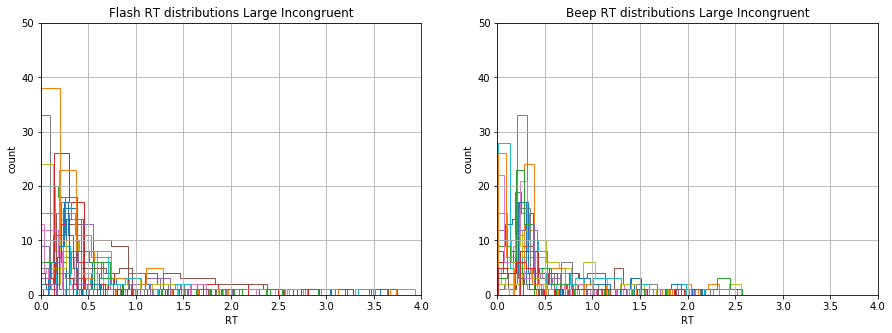

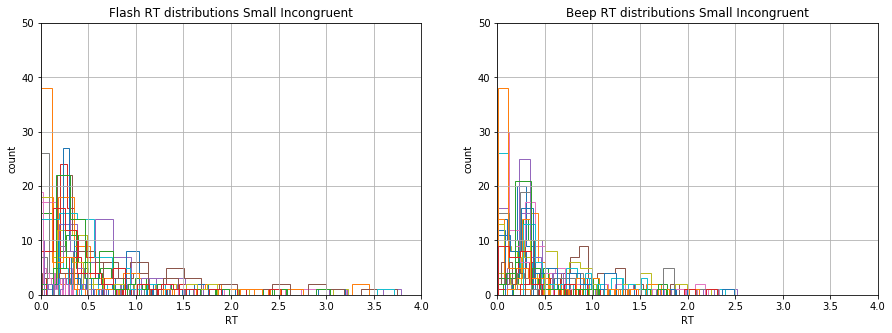

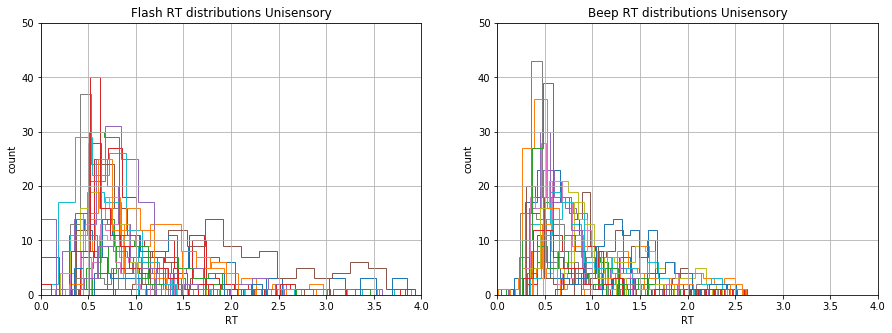

In [20]:
largeincfig = plt.figure(figsize=(15, 5))
ax = largeincfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Large Incongruent')
ax.set_xlim([0, 4])
ax.set_ylim([0, 50])
for i, subj_data in largeincf.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# one row has -1 rt

ax = largeincfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Large Incongruent')
ax.set_xlim([0, 4])
ax.set_ylim([0, 50])
for i, subj_data in largeincb.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
smallincfig = plt.figure(figsize=(15, 5))
ax = smallincfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Small Incongruent')
ax.set_xlim([0, 4])
ax.set_ylim([0, 50])
for i, subj_data in smallincf.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = smallincfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Small Incongruent')
ax.set_xlim([0, 4])
ax.set_ylim([0, 50])
for i, subj_data in smallincb.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
unifig2 = plt.figure(figsize=(15, 5))
ax = unifig2.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
ax.set_xlim([0, 4])
ax.set_ylim([0, 50])
for i, subj_data in unif.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = unifig2.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Unisensory')
ax.set_xlim([0, 4])
ax.set_ylim([0, 50])
for i, subj_data in unib.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

### Test difference in distribution for large and small incongruencies

In [21]:
# if we assume trials within subjects are independent we can use the Mann-Whitney U Test 

from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(smallincf['rt'], largeincf['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = mannwhitneyu(smallincb['rt'], largeincb['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=690911.000, p=0.335
Statistics=688842.000, p=0.395


In [22]:
stat, p = mannwhitneyu(congf['rt'], unif['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(congb['rt'], unib['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(incongb['rt'], unib['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(incongb['rt'], unib['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1135286.000, p=0.000
Statistics=1276229.000, p=0.000
Statistics=3394867.000, p=0.000
Statistics=3394867.000, p=0.000


### Compare congruent and unisensory trials for flash first trials

In [101]:
### Calculate standard error for each condition(flash response)
def calcstderr(data, col='responsef'):
    num = float(0)
    count = 0
    for i, subj_data in data.groupby('Subj_id'):
        num += subj_data[col].std()
        count += 1
    return(num/count)

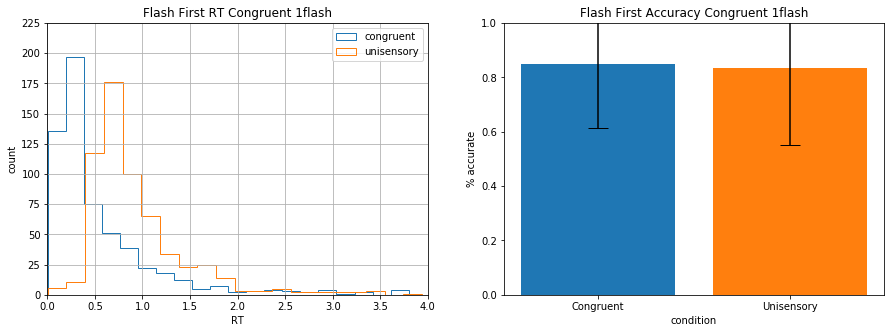

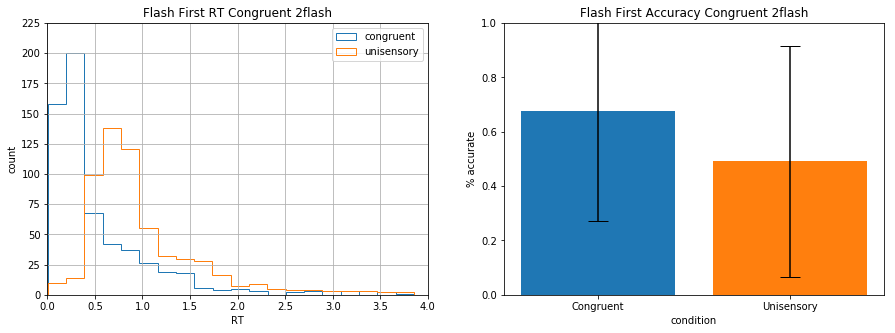

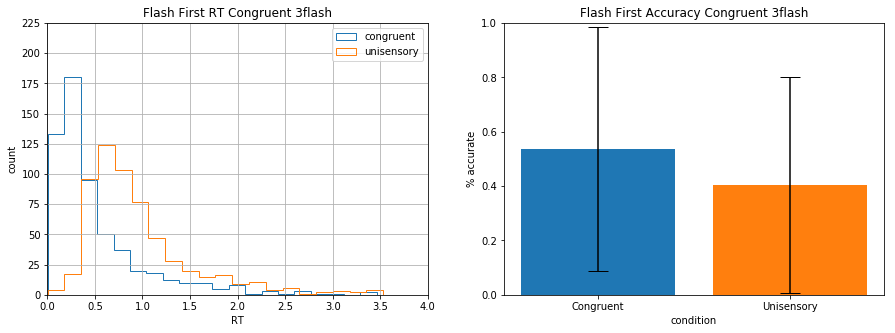

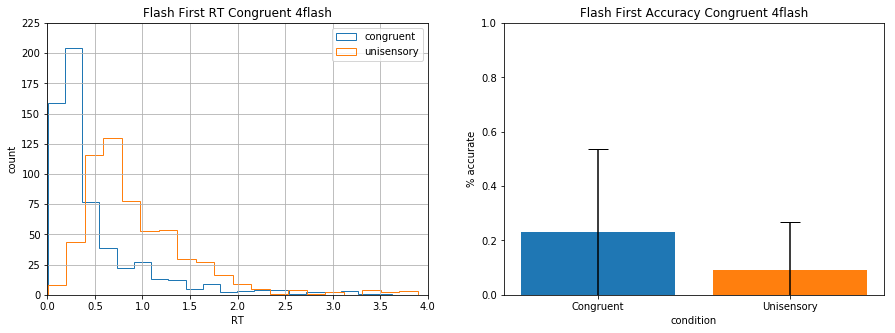

In [102]:
# plot side by side rt and accuracy for congruent and unisensory
def plotflash2rtacc(data1, data2, title1, title2):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121, xlabel='RT', ylabel='count', title=title1)
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 225])
    data1.rt.hist(bins=20, histtype='step', ax=ax, label="congruent")
    data2.rt.hist(bins=20, histtype='step', ax=ax, label="unisensory")
    fig.gca().legend(loc="upper right")

    data1acc = float(len(data1.loc[data1['responsef'] == 1])) / float(len(data1))
    data2acc = float(len(data2.loc[data2['responsef'] == 1])) / float(len(data2))
    data1err = calcstderr(data1)
    data2err = calcstderr(data2)

    ax = fig.add_subplot(122, xlabel='condition', ylabel='% accurate', title=title2)
    objects = ('Congruent', 'Unisensory')
    y_pos = np.arange(len(objects))
    performance = [data1acc, data2acc]

    plt.bar(y_pos, performance, yerr=[data1err, data2err], color=['#1f77b4', '#ff7f0e'], ecolor='black', capsize=10)
    plt.xticks(y_pos, objects)
    plt.ylim([0,1])

plotflash2rtacc(cong1f, uni1f, 'Flash First RT Congruent 1flash', 'Flash First Accuracy Congruent 1flash')
plotflash2rtacc(cong2f, uni2f, 'Flash First RT Congruent 2flash', 'Flash First Accuracy Congruent 2flash')
plotflash2rtacc(cong3f, uni3f, 'Flash First RT Congruent 3flash', 'Flash First Accuracy Congruent 3flash')
plotflash2rtacc(cong4f, uni4f, 'Flash First RT Congruent 4flash', 'Flash First Accuracy Congruent 4flash')

### Tests for rt distributions

In [184]:
stat, p = mannwhitneyu(cong1f['rt'], unif['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(cong2f['rt'], unif['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(cong3f['rt'], unif['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(cong4f['rt'], unif['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=300829.000, p=0.000
Statistics=297230.000, p=0.000
Statistics=280873.000, p=0.000
Statistics=256354.000, p=0.000


### Tests for accuracy distributions

In [188]:
# calculate within subject accuracies
def calcacc(data, col='responsef'):
    arr = np.empty((1,1))
    for i, subj_id in data.groupby('Subj_id'):
        acc = float(len(subj_id.loc[subj_id[col] == 1])) / float(len(subj_id[col]))
        arr = np.append(arr, acc)
    return(arr[1:])

In [186]:
# differences can be assumed to be approximately normally distributed
# t-test is robust enough to not require strong normality

# 1flash 
cong1facc = calcacc(cong1f)
uni1facc = calcacc(uni1f)
print(stats.ttest_rel(cong1facc, uni1facc))

# 2flash
cong2facc = calcacc(cong2f)
uni2facc = calcacc(uni2f)
print(stats.ttest_rel(cong2facc, uni2facc))

# 3flash
cong3facc = calcacc(cong3f)
uni3facc = calcacc(uni3f)
print(stats.ttest_rel(cong3facc, uni3facc))

# 4flash
cong4facc = calcacc(cong4f)
uni4facc = calcacc(uni4f)
print(stats.ttest_rel(cong4facc, uni4facc))

## all except the 1flash trials have significantly different means between congruent and unisensory trials

Ttest_relResult(statistic=1.2594424209474846, pvalue=0.21998178719589367)
Ttest_relResult(statistic=3.916061862735457, pvalue=0.0006512341392183512)
Ttest_relResult(statistic=2.523383082249855, pvalue=0.018655498226614036)
Ttest_relResult(statistic=3.690939795706518, pvalue=0.0011459604850609685)


### Compare congruent and unisensory trials for beep first trials

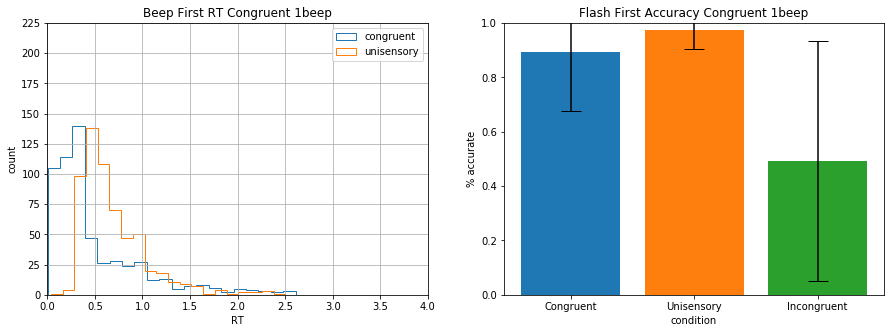

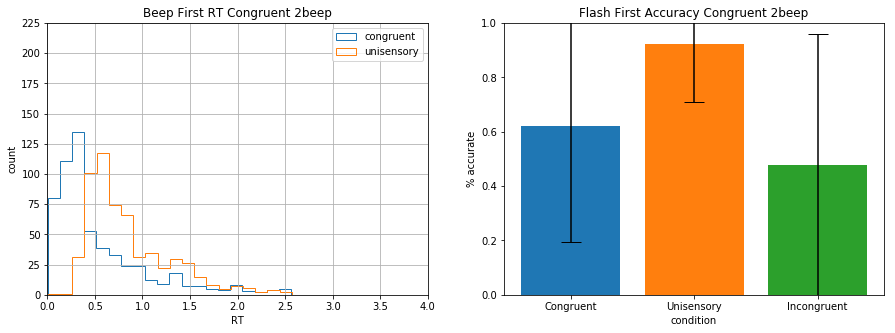

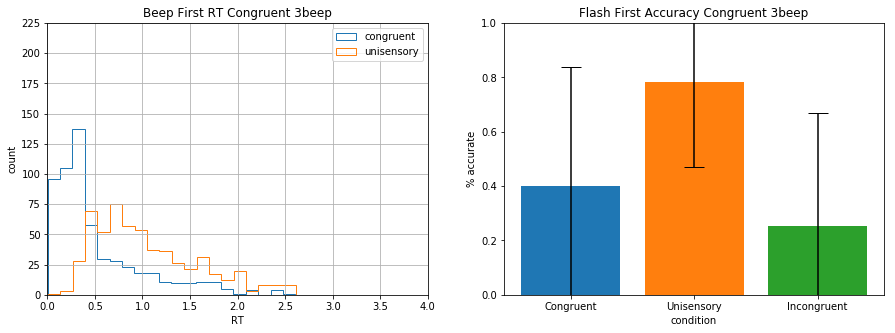

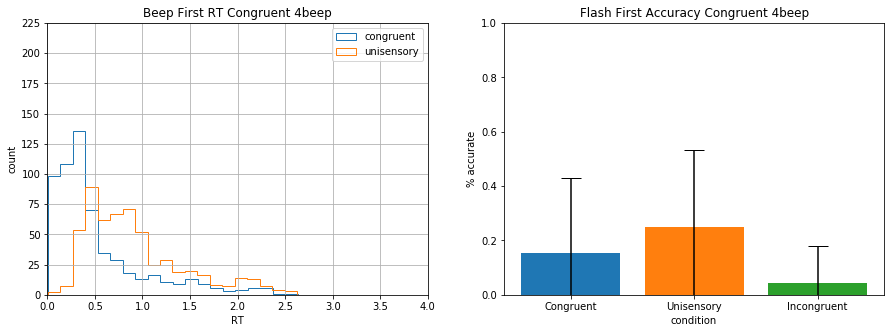

In [105]:
def plotbeep3rtacc(cong, uni, incong, title1, title2):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121, xlabel='RT', ylabel='count', title=title1)
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 225])
    cong.rt.hist(bins=20, histtype='step', ax=ax, label="congruent")
    uni.rt.hist(bins=20, histtype='step', ax=ax, label="unisensory")
    fig.gca().legend(loc="upper right")

    congacc = float(len(cong.loc[cong['responsef'] == 1])) / float(len(cong))
    uniacc = float(len(uni.loc[uni['responseb'] == 1])) / float(len(uni))
    incongacc = float(len(incong.loc[incong['responsef'] == 1])) / float(len(incong))
    congerr = calcstderr(cong)
    unierr = calcstderr(uni, 'responseb')
    incongerr = calcstderr(incong)

    ax = fig.add_subplot(122, xlabel='condition', ylabel='% accurate', title=title2)
    objects = ('Congruent', 'Unisensory', 'Incongruent')
    y_pos = np.arange(len(objects))
    performance = [congacc, uniacc, incongacc]

    plt.bar(y_pos, performance, yerr=[congerr, unierr, incongerr], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], ecolor='black', capsize=10)
    plt.xticks(y_pos, objects)
    plt.ylim([0,1])
    
plotbeep3rtacc(cong1b, uni1b, incong1b, 'Beep First RT Congruent 1beep', 'Flash First Accuracy Congruent 1beep')
plotbeep3rtacc(cong2b, uni2b, incong2b, 'Beep First RT Congruent 2beep', 'Flash First Accuracy Congruent 2beep')
plotbeep3rtacc(cong3b, uni3b, incong3b, 'Beep First RT Congruent 3beep', 'Flash First Accuracy Congruent 3beep')
plotbeep3rtacc(cong4b, uni4b, incong4b, 'Beep First RT Congruent 4beep', 'Flash First Accuracy Congruent 4beep')

### Test for rt distributions

In [198]:
stat, p = mannwhitneyu(cong1b['rt'], unib['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(cong2b['rt'], unib['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(cong3b['rt'], unib['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(cong4b['rt'], unib['rt'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=248819.000, p=0.000
Statistics=275338.000, p=0.000
Statistics=265366.000, p=0.000
Statistics=259916.000, p=0.000


### Test for accuracy distributions

In [193]:
# 1beep
cong1bacc = calcacc(cong1b)
uni1bacc = calcacc(uni1b, 'responseb')
print(stats.ttest_rel(cong1bacc, uni1bacc))

# 2beep
cong2bacc = calcacc(cong2b)
uni2bacc = calcacc(uni2b, 'responseb')
print(stats.ttest_rel(cong2bacc, uni2bacc))

# 3beep
cong3bacc = calcacc(cong3b)
uni3bacc = calcacc(uni3b, 'responseb')
print(stats.ttest_rel(cong3bacc, uni3bacc))

# 4beep
cong4bacc = calcacc(cong4b)
uni4bacc = calcacc(uni4b, 'responseb')
print(stats.ttest_rel(cong4bacc, uni4bacc))

# all distributions have significantly different means

Ttest_relResult(statistic=-3.513154831078755, pvalue=0.0018671995707987869)
Ttest_relResult(statistic=-6.601538946526744, pvalue=9.795247495673761e-07)
Ttest_relResult(statistic=-6.70424913212772, pvalue=7.717917318772582e-07)
Ttest_relResult(statistic=-2.0718508012578107, pvalue=0.04967572688776233)


### Compare all congruent flash first trials to unisensory

(0, 1)

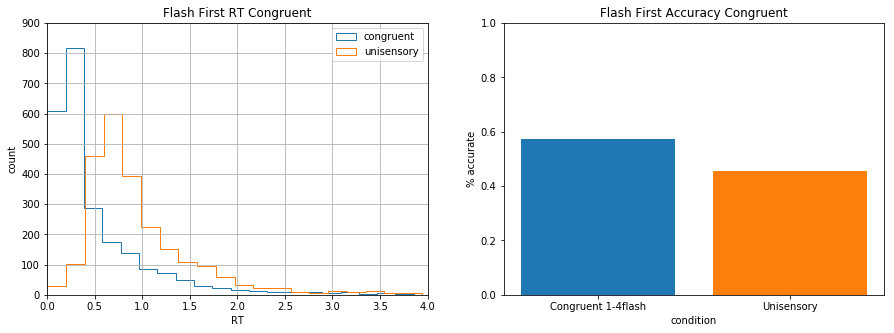

In [190]:
fig9 = plt.figure(figsize=(15,5))
ax = fig9.add_subplot(121, xlabel='RT', ylabel='count', title='Flash First RT Congruent')
ax.set_xlim([0, 4])
ax.set_ylim([0, 900])
congf.rt.hist(bins=20, histtype='step', ax=ax, label="congruent")
unif.rt.hist(bins=20, histtype='step', ax=ax, label="unisensory")
fig9.gca().legend(loc="upper right")

congfacc = float(len(congf.loc[congf['responsef'] == 1])) / float(len(congf))
ax = fig9.add_subplot(122, xlabel='condition', ylabel='% accurate', title='Flash First Accuracy Congruent')
objects = ('Congruent 1-4flash', 'Unisensory')
y_pos = np.arange(len(objects))
performance = [congfacc, unifacc]

plt.bar(y_pos, performance, color=['#1f77b4', '#ff7f0e'])
plt.xticks(y_pos, objects)
plt.ylim([0,1])

In [204]:
stat, p = mannwhitneyu(congf['responsef'], unif['responsef'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=2458747.500, p=0.000


In [311]:
#float(len(cong1f.loc[cong1f['responsef'] == 1])) / float(len(cong1f))
#float(len(unif.loc[unif['responsef'] == 1])) / float(len(unif))
plt.rcParams['axes.prop_cycle'].by_key()['color']


['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']